In [6]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.special import expi
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix

In [160]:
def csrt(conc,ti, tau=2, ts =[], cinj=[0] ):
    '''
    this function provides the time derivative for the concentration 
    in a mixing tank at ti.
    CSRT time differencial
    f = d/dt(concentration) = slope = n/tau*(delta concentration)
        delta concentration in the equation above is the difference between 
        concentration in the nth tank and n-1th tank     
    input:
            conc : a numpy list of concentrat in n number of nodes at time step ti
            ti   : time at which the slope is being derived (note: in this model ti is not used)
            n    : number of tanks in series
            tau  : some parameter of the mixing tank (units = time)
            cinj : the concentration of the fluid being injected into the 0th mixing tank
                   at the ith time step.
    '''
    
    n = len(conc)
    idx =0#= np.where(ts==ti)[0][0] # find which time step we are on[]
    #print(cinj[idx],n)
    c = np.append(cinj[idx], conc) # we append the injection 
    slope = n/tau*(c[:-1]-c[1:])
    return(slope)

In [161]:
def mixanalytical(ts, tau,c0=1,N=1):
    match N:
        case 1:
            return c0*np.exp(-ts/tau)
        case 2:
            return 2*c0*ts/tau*np.exp(-2*ts/tau)
        case 3:
            return c0*9*ts*ts/2/tau/tau*np.exp(-3*ts/tau)
        case other:
            Print('Not implemented')
            return(None)


In [162]:
class ODEsolvers():
    '''
    a class containing solvers that solves for an euation of the form 
    d/dt(y) = f(y,t)
    '''
    def __init__(self, y_init, deltaTs, f):
        '''
        initiate the object with the old value of y 
        y_init : initial values of the variable before simulation starts
        deltaTs: a list of deltaTs over which the new values for y are to be calculated
        f: is the function that provides the time derivative at each node 
        '''
        self.y_0 = y_init
        self.deltaTs = deltaTs
        self.slope = f
        self.solutions={}
        #time stamp after each time step
        ts = [sum(self.deltaTs[:i+1])for i in range(len(self.deltaTs))] 
        self.ts = np.array(ts)
        
    def euler(self,y,t, dt,*pparams, **nparams):
        '''
        returns the increment to the parameter y 
        '''
        eulerstep = self.slope(y,t,*pparams,**nparams)*dt
        return(eulerstep)
    
    def rk2(self,y,t, dt,*pparams, **nparams):
        '''
        returns the increment to the parameter y 
        '''
        k1=dt*self.slope(y,t,*pparams,**nparams)
        k2=dt*self.slope(y+k1/2,t+dt/2,*pparams,**nparams)
        return k2
    
    def rk4(self,y,t, dt,*pparams, **nparams):
        '''
        returns the increment to the parameter y 
        '''
        k1=dt*self.slope(y,t,*pparams,**nparams)
        k2=dt*self.slope(y+k1/2,t+dt/2,*pparams,**nparams)
        k3=dt*self.slope(y+k2/2,t+dt/2,*pparams,**nparams)
        k4=dt*self.slope(y+k3,t+dt,*pparams,**nparams)
        return (k1+2*k2+2*k3+k4)/6
    
    def solver(self, *pparams, method='euler', **nparams):
        solution = []
        
        match method:
            case 'euler':
                solver = self.euler
            case 'rk2':
                solver = self.rk2
            case 'rk4':
                solver = self.rk4
            case other:
                print('Not implemented, choosing rk4 instead.')
                solver = self.rk4
            
        y_now = self.y_0    # set y values 
        for ti,dt in zip(self.ts, self.deltaTs):
            step = solver(y_now, ti, dt, *pparams, **nparams)
            y_next = y_now+step
            solution.append(y_next)
            y_now= y_next
        solution = np.array(solution)
        self.solutions[method]=solution
        return(solution[:,-1])
            
        

In [198]:
def solver_method_plot(tau = 2,N = 1,dt = 3,Tmax = 20):
    Nt = int(Tmax/dt)
    #print(Nt)
    y_init = np.append(1,np.zeros(N-1))
    deltaTs = np.ones(Nt)*dt
    cinj =np.zeros(Nt) # no injection
    cinj, deltaTs

    solver = ODEsolvers(y_init, deltaTs, f=csrt)
    nparams = {'tau':tau, 'ts':solver.ts, 'cinj':cinj}

    soln1 =solver.solver(**nparams)
    soln2 =solver.solver(method='rk2',**nparams)
    soln3 =solver.solver(method='rk4',**nparams)
    ts=solver.ts
    analitical= mixanalytical(solver.ts,tau,N=N)

    fig, ax=plt.subplots()
    ax.plot(ts, analitical,'-o',markersize=7, label='analytical')
    ax.plot(ts, soln1,'-*',markersize=7, label='numerical, euler')
    ax.plot(ts, soln2,'-*',markersize=5, label='numerical, rk2')
    ax.plot(ts, soln3,'-*',markersize=2, label='numerical, rk4')
    plt.legend()


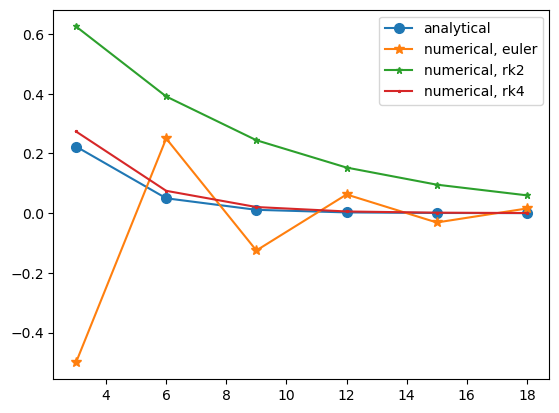

In [199]:
solver_method_plot()

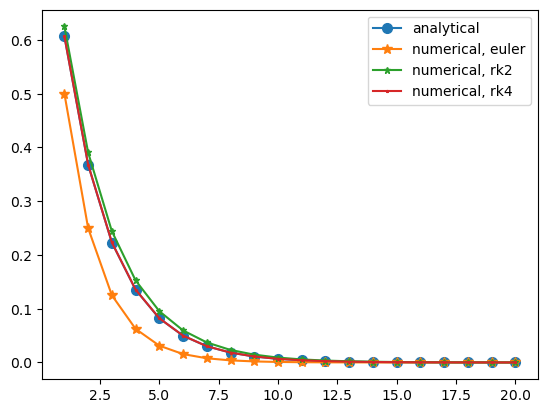

In [200]:
solver_method_plot(dt = 1,Tmax = 20)

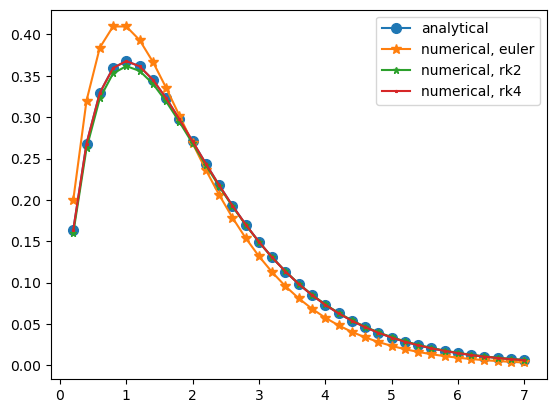

In [204]:
solver_method_plot(dt = .2,Tmax = 7,N=2)

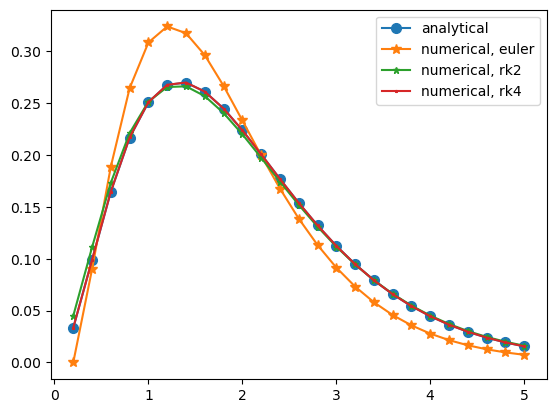

In [205]:
solver_method_plot(dt = .2,Tmax = 5,N=3)

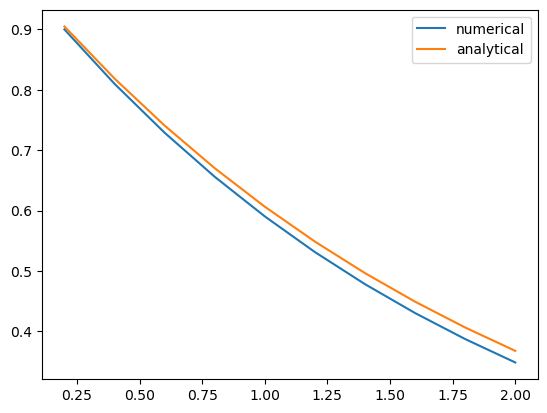

In [152]:
fig, ax=plt.subplots()
ax.plot(ts, numerical, label='numerical, euler')
ax.plot(ts, analitical, label='analytical')
plt.legend()

In [122]:
soln

array([[-0.05      ],
       [-0.0525    ],
       [-0.055125  ],
       [-0.05788125],
       [-0.06077531],
       [-0.06381408],
       [-0.06700478],
       [-0.07035502],
       [-0.07387277],
       [-0.07756641],
       [-0.08144473],
       [-0.08551697],
       [-0.08979282],
       [-0.09428246],
       [-0.09899658],
       [-0.10394641],
       [-0.10914373],
       [-0.11460092],
       [-0.12033096],
       [-0.12634751]])

In [117]:
solln = []
a =1
for i in soln:
    a= a-i
    solln.append(a)
    
solln = np.array(solln).flatten()

In [118]:
soln

array([[-0.05      ],
       [-0.0525    ],
       [-0.055125  ],
       [-0.05788125],
       [-0.06077531],
       [-0.06381408],
       [-0.06700478],
       [-0.07035502],
       [-0.07387277],
       [-0.07756641],
       [-0.08144473],
       [-0.08551697],
       [-0.08979282],
       [-0.09428246],
       [-0.09899658],
       [-0.10394641],
       [-0.10914373],
       [-0.11460092],
       [-0.12033096],
       [-0.12634751]])

array([0.97530991, 0.95122942, 0.92774349, 0.90483742, 0.8824969 ,
       0.86070798, 0.83945702, 0.81873075, 0.79851622, 0.77880078,
       0.75957212, 0.74081822, 0.72252735, 0.70468809, 0.68728928,
       0.67032005, 0.65376979, 0.63762815, 0.62188506, 0.60653066,
       0.59155536, 0.57694981, 0.56270487, 0.54881164, 0.53526143,
       0.52204578, 0.50915642, 0.4965853 , 0.48432457, 0.47236655,
       0.46070378, 0.44932896, 0.43823499, 0.42741493, 0.41686202,
       0.40656966, 0.39653142, 0.38674102, 0.37719235, 0.36787944])

In [119]:
solln

array([1.05      , 1.1025    , 1.157625  , 1.21550625, 1.27628156,
       1.34009564, 1.40710042, 1.47745544, 1.55132822, 1.62889463,
       1.71033936, 1.79585633, 1.88564914, 1.9799316 , 2.07892818,
       2.18287459, 2.29201832, 2.40661923, 2.5269502 , 2.65329771])

In [109]:
analytical-solln

array([0.00030991, 0.00060442, 0.00088411, 0.00114953, 0.00140121,
       0.00163968, 0.00186543, 0.00207895, 0.00228071, 0.00247116,
       0.00265074, 0.00281987, 0.00297897, 0.00312841, 0.00326859,
       0.00339988, 0.00352262, 0.00363717, 0.00374385, 0.00384298,
       0.00393488, 0.00401983, 0.00409814, 0.00417008, 0.00423591,
       0.0042959 , 0.00435029, 0.00439932, 0.00444324, 0.00448225,
       0.00451659, 0.00454645, 0.00457204, 0.00459356, 0.00461118,
       0.00462509, 0.00463546, 0.00464247, 0.00464626, 0.004647  ])

In [58]:
2*solver.ts/tau*np.exp(-2*solver.ts/tau)

array([0.09048374, 0.16374615, 0.22224547, 0.26812802, 0.30326533,
       0.32928698, 0.34760971, 0.35946317, 0.36591269, 0.36787944])

In [43]:
solver.ts

[0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6,
 0.7,
 0.7999999999999999,
 0.8999999999999999,
 0.9999999999999999]

In [14]:
a =np.array([1,2,3,2])
np.where(a==2)[0]

TypeError: tuple indices must be integers or slices, not tuple

{'a': 'Real', 'b': 'Python', 'c': 'Is', 'd': 'Great', 'e': '!'}
RealPythonIsGreat!
